## Time Series Clustering For Forecasting Preparation

The M5 dataset is a set of time series of daily sales by item Categories, Departments, Stores, and Items. These levels of granularity have a heirarchical structure, in that:
- A `Category` has multiple `Departments`
- A `Department` spans across multiple `Stores`
- A `Department` contains multiple `Items`
- A combination of `Item` and `Store` is a the most granular level of series (SKU).

Unlike more vanilla time series forecasting tasks - where one uses a single series to predict the future of the series, this structure allows for transfer learning between series.

For example: It may be that a group of items have similar sales patterns, due to seasonality in demand or supply, etc. Thus, it would make sense for a model to learn learn shared patterns to provide more robust forecasts.

On the other hand, demand for groups of items might differ substancially due to external forces. Training a model to try and find similarities between these groups might only introduce noise - as the demand/supply for these items are structurally different.

### Clustering series

The purpose of this notebook is to demonstrate how we might group items that have similar underlying structure before diving into modeling using several clustering approaches. This way, we could pre-process series within groups in a similar way, and train a model for each cluster which specializes in learning this underlying structure.

In this notebook I'll use a naive heirarchical method to cluster the series, point out the shortcoming of this approach, and speak about a method to approach these shortcomings called Dynamic Time Warping.

### Load packages and data

In [ ]:
# will need this later for dynamic time warping
!pip install dtw-python

     |████████████████████████████████| 255 kB 10.1 MB/s 
  Created wheel for dtw-python: filename=dtw_python-1.0.5-cp36-cp36m-linux_x86_64.whl size=523846 sha256=e0fe9ae539af8b9f82b18d49b219a8933b5faccd1bbf04b53a909697f8ee63b9
  Stored in directory: /root/.cache/pip/wheels/09/ea/b1/4fb64a0c9c77f490cc9b4f8b24927c5c70f0a658e97d1e4f37
Successfully built dtw-python


In [ ]:
import numpy as np
import pandas as pd
from random import sample
import random
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
# dynamic time warping
from dtw import *

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



#### Sales data only

For this notebook, I'll only use `sales_train_validation.csv` dataset, which includes daily sales at an item, store, department and category level.

In [ ]:
# load data
sales = pd.read_csv("../input/m5-forecasting-uncertainty/sales_train_validation.csv")

#### look at a single item's rows to get a feel for the data structure


In [ ]:
sales.loc[sales.item_id == 'HOBBIES_1_001']\
    .sort_values("id")\
    .head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
3049,HOBBIES_1_001_CA_2_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_2,CA,0,0,0,0,...,0,0,1,2,0,4,0,0,2,2
6098,HOBBIES_1_001_CA_3_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_3,CA,0,0,0,0,...,0,2,4,0,1,1,1,0,3,3
9147,HOBBIES_1_001_CA_4_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_4,CA,0,0,0,0,...,1,0,0,1,0,1,0,1,2,1
12196,HOBBIES_1_001_TX_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,TX_1,TX,0,0,0,0,...,0,0,0,0,1,0,1,0,0,2


- Each item in multiple rows: once for each of the stores it's sold in
- All items are part of the same category (e.g, `HOBBIES`), and department (`HOBBIES_1`)
- The actual time series are stored in wide format - the series are stored in columes ranging from `1` to `1913`, indicating the days since the start of the time period in question

---

### Get a feel for some time series' shapes

Before we jump into pre-processing, it's useful to look at a sample of series to see if anything jumps out at us that will motivate how to move forward.

In [ ]:
# make time series columns integers for more meaningful plotting (can order numbers)
_cols = list(sales.columns)
sales.columns = pd.Index(_cols[:6] + [int(c.replace("d_","")) for c in _cols[6:]])
del _cols

#### Functions for isolating particular...

- item_id's (combination of item and store)
- items (aggregated over stores)
- departments (aggregated over items and stores)

In [ ]:
def series_from_id(_id:str) -> pd.DataFrame:
    """
    Get a daily time series for a single id
    """
    return sales.loc[sales.id == _id]\
    .iloc[:,6:]\
    .T

# Create a global lookup table for fast plotting by department
daily_sales_dept_lookup = sales[["dept_id"] + list(sales.columns[6:])]\
    .melt(id_vars = "dept_id")\
    .groupby("dept_id variable".split())\
    .agg({"value":"sum"})

def series_from_dept(dept:str) -> pd.DataFrame:
    return daily_sales_dept_lookup.loc[dept]

# create a global lookup table for fast plotting by item
daily_sales_item_lookup = sales[["item_id"] + list(sales.columns[6:])]\
    .melt(id_vars = "item_id")\
    .groupby("item_id variable".split())\
    .agg({"value":"sum"})

def series_from_item(item:str) -> pd.DataFrame:
    return daily_sales_item_lookup.loc[item]

"""
Time series for particular items are quite noisy on a daily level.
Provide the ability to bin sales (for examply - to a weekly bin) for more stable plots
"""
def series_from_id_binned(_id:str, bin_every:int = 7) -> pd.DataFrame:
    """
    Get the sales for an id, grouped by a fixed interval (default 7 - weekly)
    """
    t = series_from_id(_id).reset_index()
    t["index"] = t.index.map(lambda x: x - (x % bin_every))
    t.columns = pd.Index(["day", "sales"])
    return t.groupby("day")\
        .agg({"sales":"sum"})

def series_from_dept_binned(dept:str, bin_every:int = 7) -> pd.DataFrame:
    """
    Get the sales for a department, grouped by a fixed interval (default 7 - weekly)
    """
    t = series_from_dept(dept).reset_index()
    t["variable"] = t.index.map(lambda x: x - (x % bin_every))
    return t.groupby("variable")\
        .agg({"value":"sum"})

def series_from_item_binned(item:str, bin_every:int = 7) -> pd.DataFrame:
    """
    Get the sales for an item (across stores), grouped by a fixed interval (default 7 - weekly)
    """
    t = series_from_item(item).reset_index()
    t["variable"] = t.index.map(lambda x: x - (x % bin_every))
    return t.groupby("variable")\
        .agg({"value":"sum"})

#### Plotting 5 unique items (`id`'s)


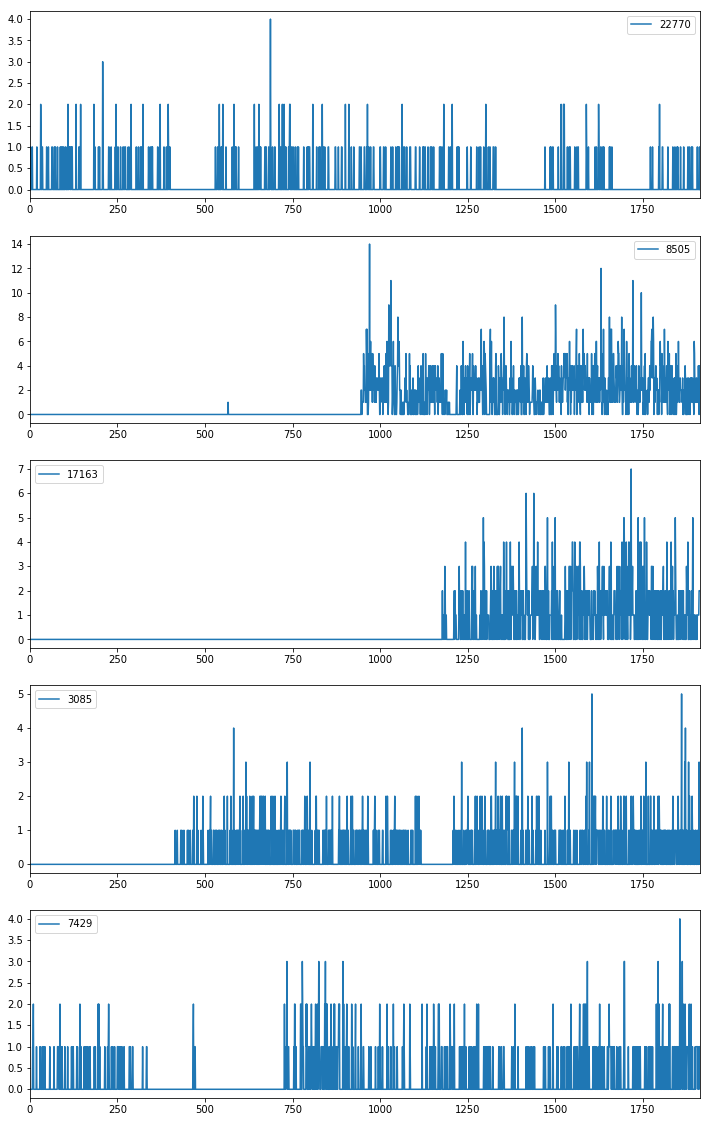

In [ ]:
fig, axes = plt.subplots(nrows = 5, figsize = (12,20))
_ids = sales["id"].sample(n = 5, random_state = 1)
for i in range(len(_ids)):
    series_from_id(_ids.iloc[i]).plot(ax = axes[i])
del _ids

#### Notes

- We see some clear differences in the series shapes - some have traffic all throughout while others don't start until later on
- Plus the scale is different. The first series gets 1-2 sales a day, while the second gets 2-6 (after a period of relative quiet)

#### Action Items

- To avoid dealing with very noisy series, I'll bin sales by week, which will remove weekly seasonality and lead the number of sales per time unit to be less volitile.

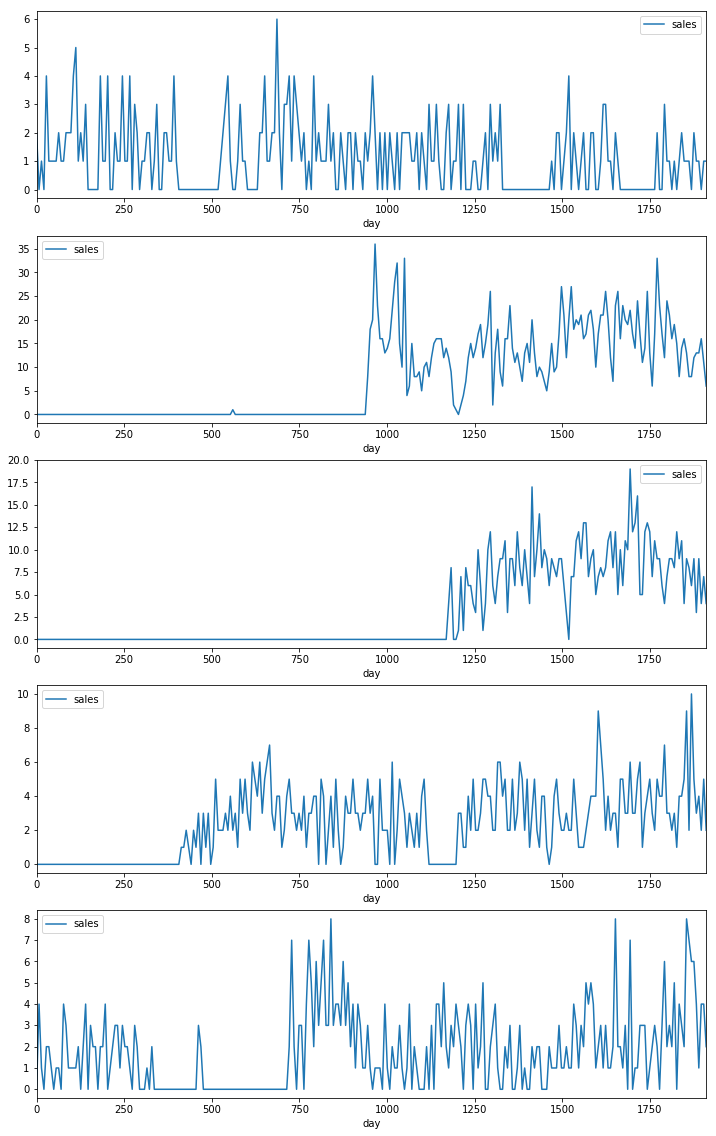

In [ ]:
# bin the items by week and plot again
fig, axes = plt.subplots(nrows = 5, figsize = (12,20))
_ids = sales["id"].sample(n = 5, random_state = 1)
for i in range(len(_ids)):
    series_from_id_binned(_ids.iloc[i], bin_every = 7).plot(ax = axes[i])


#### Notes

- For the first and second series, **sales only start at a certain point**, and then they are quite strong. This is probably because these items were introduced by Walmart sometime during this time period.
- This is important, as if we are to train a model over the entire time period, then we will dilute any real signal with a period of zero sales. Instead, we need a way to clip the begining of the series that has no sales, and only start training after the point that we have data.

---

### 5 Example `items`

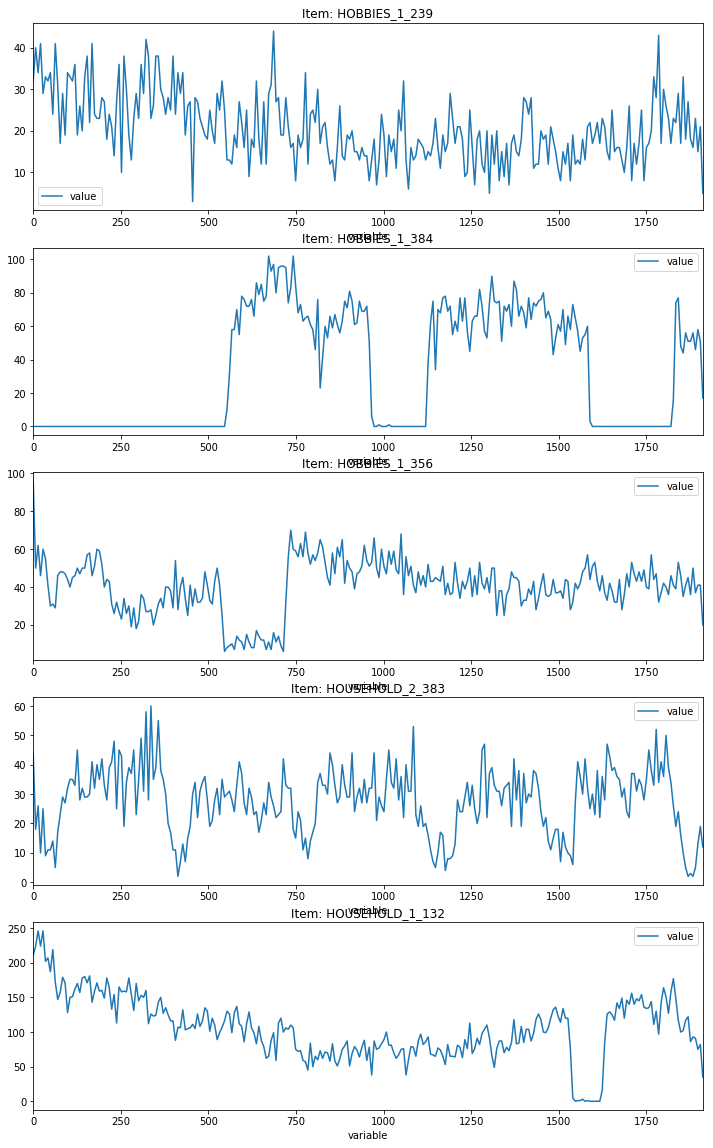

In [ ]:
fig, axes = plt.subplots(nrows = 5, figsize = (12,20))
random.seed(2)
_ids = sample(list(sales["item_id"].unique()), 5)
for i in range(len(_ids)):
    series_from_item_binned(_ids[i], bin_every = 7).plot(ax = axes[i])
    axes[i].set_title("Item: %s" % _ids[i])

## Notes

- It's clear that there are some interventions that Walmart makes - as sales may dip all of a sudden quite dramatically. For example, it looks like after months of steady sales, sales dip for the first item plotted above - maybe because they're taken off the shelves at one or more store.
- Similarly, the last chart shows that an item may be introduced and then removed from the shelves on a periodic basis.
- Predicting how volitile these series are will rely on identifying which items are likely to have these types of interventions - as a sudden decrease in sales may lead to high inter-quartile ranges for a period's sales.

---

### 5 example departments

Finally, plotting 5 randomly selected departments

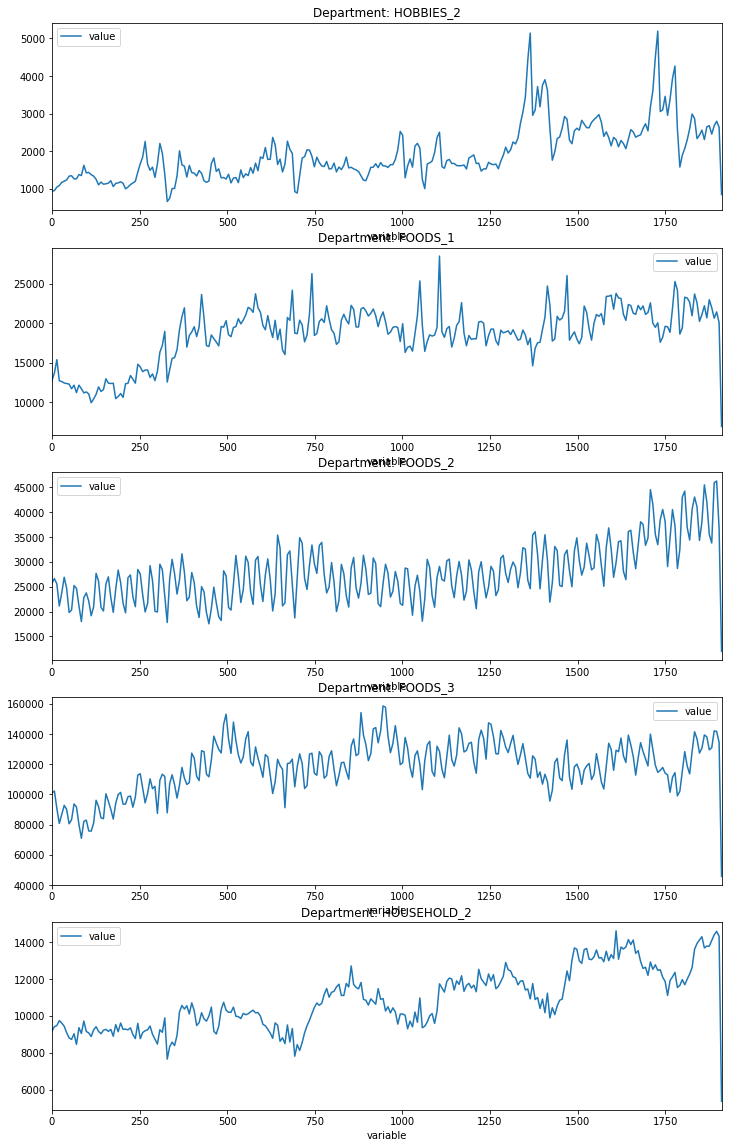

In [ ]:
fig, axes = plt.subplots(nrows = 5, figsize = (12,20))
random.seed(3)
_ids = sample(list(sales["dept_id"].unique()), 5)
for i in range(len(_ids)):
    series_from_dept_binned(_ids[i], bin_every = 7).plot(ax = axes[i])
    axes[i].set_title("Department: %s" % _ids[i])

### Notes

- At the Department level, this starts to look like a time series that which are more straight forward to work with. We see clear trend, seasonal (monthly, as I'm binning by weeks as it is) and periodic components.
- Getting quantiles for these series could be done though the confidence intervals of a traditional parametric time series model (S-ARIMA), or a quantile regression.

---

### Clustering on an item level

For the purposes of this notebook, I want to pick a granularity to cluster series on that will be simultaneously useful, but not subject to too much noise.

Clustering entire departments together doesn't seeem sufficiently useful, as there are only 7 departments - and could probably be forecasted individually.

Clustering at the lowest level of granularity (`item_id`) would likely be very volitile, and sort of defeats the purpose of clustering items. I want to understand what _items are similar_ - both in terms of demand and how Walmart changes. Though it could be that demand and store strategies change between stores, clustering items directly (independent of store) serves to achieve this purpose most directly.

I'm also going to group by week, to remove weekly seasonality (for simplicity). This implicitly assumes that all items have similar weekly seasonality.

#### Rescaling series

Some items are sold at a way higher rate than others. When we cluster, we don't want the result of our clustering to split popular vs unpopular items. Rather, we're interested in distinguishing the shape between items.

Thus, I'll rescale each item according to it's global mean.

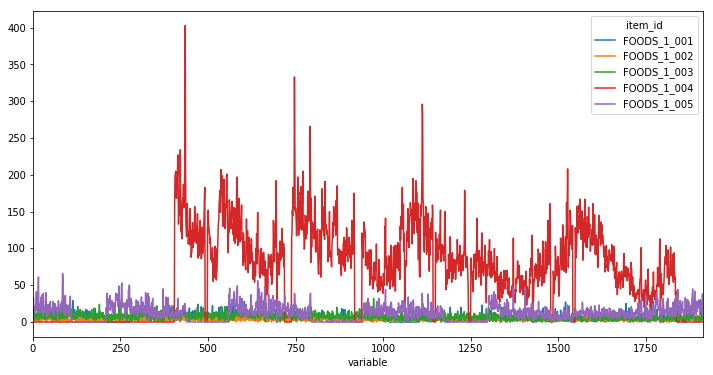

In [ ]:
# plotting 10 series, for demonstration
daily_sales_item_lookup.pivot_table(index = "variable", columns = "item_id", values = "value")\
    .iloc[:,:5]\
    .plot(figsize = (12,6))

In [ ]:
# Create a lookup table for scaled series
daily_sales_item_lookup_scaled = daily_sales_item_lookup\
    .pivot_table(index = "variable", columns = "item_id", values = "value").copy()
daily_sales_item_lookup_scaled = daily_sales_item_lookup_scaled.div(daily_sales_item_lookup_scaled.mean(axis = 0), axis = 1)
# bin by week
daily_sales_item_lookup_scaled_weekly = daily_sales_item_lookup_scaled.copy().reset_index()
daily_sales_item_lookup_scaled_weekly["variable"] = daily_sales_item_lookup_scaled_weekly.variable.map(lambda x: x - (x%7))
daily_sales_item_lookup_scaled_weekly = daily_sales_item_lookup_scaled_weekly.groupby("variable").mean()

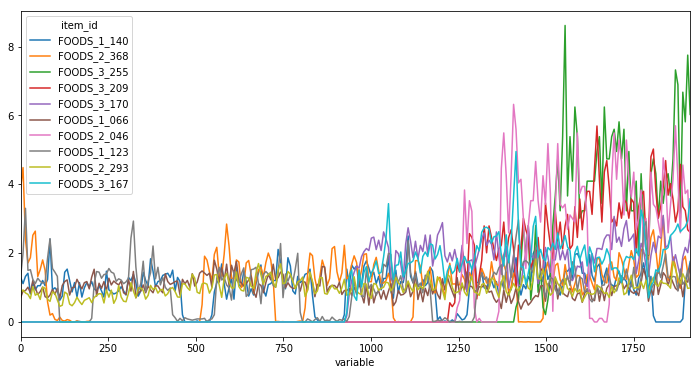

In [ ]:
# plot those same series, but this time normalized by the series' means.
random.seed(1)
daily_sales_item_lookup_scaled_weekly.iloc[:,random.sample(range(1000),10)]\
    .plot(figsize = (12,6))

Now that we're scale invariant, we can focus on shape.

---

## Heirarchical clustering

As a quick and dirty first approach I'll cluster the series using a simple [Heirarchical Clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering) method. To do so, we treat each time series as a vector of the same length, and cluster them as we would any other set of vectors.

In this way, we're grouping together series that behave similar at the same points in time. This method does not recognize _shifts_ in otherwise similar series, as I'll discuss later.

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster, ward, dendrogram

In [ ]:
# heirarchical clustering of scales weekly item sales.
clf = AgglomerativeClustering(n_clusters=None, distance_threshold = 0).fit(daily_sales_item_lookup_scaled_weekly.T.values)

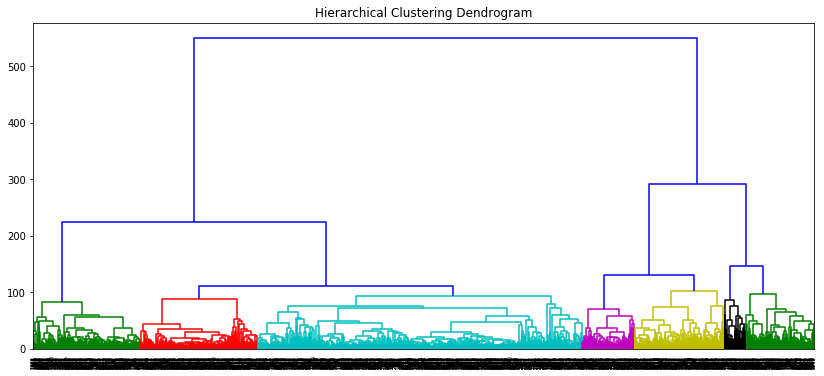

In [ ]:
# given a linkage model, plog dendogram, with the colors indicated by the a cutoff point at which we define clusters
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    return linkage_matrix

plt.figure(figsize = (14,6))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
Z = plot_dendrogram(clf, p=5, color_threshold = 110)
plt.show()

In [ ]:
# extract clusters from dendogram
clusters = fcluster(Z, 100, criterion='distance')
# create a lookup table for series in a given cluster
daily_sales_item_lookup_scaled_clustered = daily_sales_item_lookup_scaled_weekly.T.reset_index()
daily_sales_item_lookup_scaled_clustered["cluster"] = clusters
daily_sales_item_lookup_scaled_clustered = daily_sales_item_lookup_scaled_clustered.set_index("cluster item_id".split())\
    .sort_index()


#### Plot samples of series from clusters

To get a feel for what this clustering method has actually produced, we can plot a sample of series from each cluster, and try and see what is in common between them.

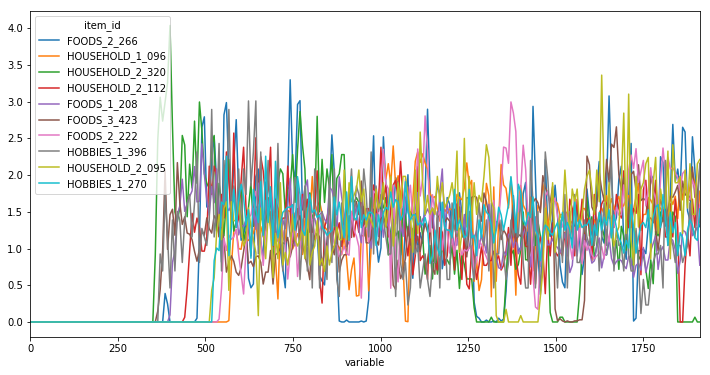

In [ ]:
# cluster 1
random.seed(1)
daily_sales_item_lookup_scaled_clustered.loc[1]\
    .T\
    .iloc[:, random.sample(range(daily_sales_item_lookup_scaled_clustered.loc[1].shape[0]), 10)]\
    .plot(figsize = (12,6))

The series in cluster 1 seem to be similar in that they start with very few sales up until day 300-500, and then have relatively steady sales past that point.

The series in this cluster might be pre-processed in a similar way, by cutting off the first 300 days of data, for example.

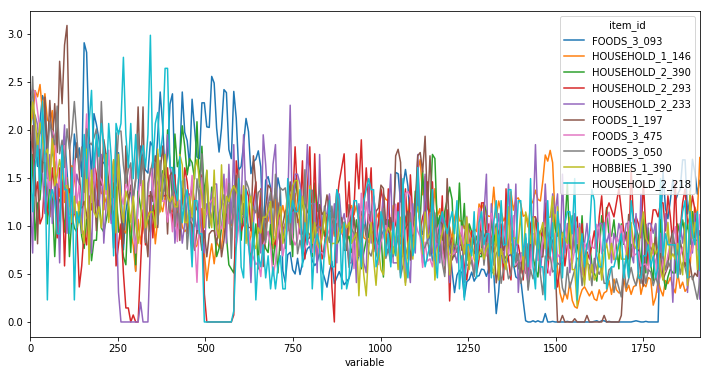

In [ ]:
# series 2
random.seed(1)
daily_sales_item_lookup_scaled_clustered.loc[2]\
    .T\
    .iloc[:, random.sample(range(daily_sales_item_lookup_scaled_clustered.loc[2].shape[0]), 10)]\
    .plot(figsize = (12,6))

The series in cluster two generally show a period of decreasing trend, and then they stabalize around 700-1000 days into the time frame.



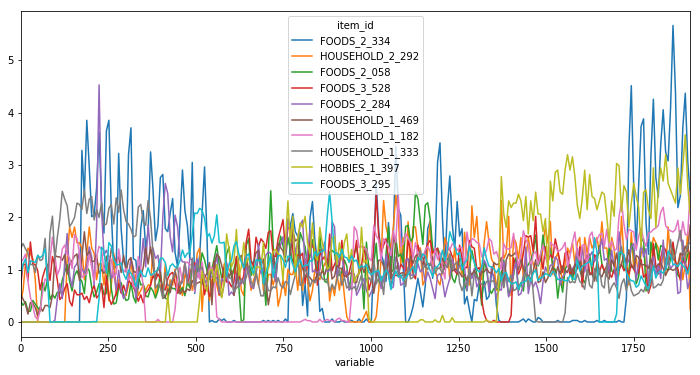

In [ ]:
# cluster 3
random.seed(1)
daily_sales_item_lookup_scaled_clustered.loc[3]\
    .T\
    .iloc[:, random.sample(range(daily_sales_item_lookup_scaled_clustered.loc[3].shape[0]), 10)]\
    .plot(figsize = (12,6))

Cluster 3... well this cluster doesn't tell a very clear story. In the dendogram above, you'll see that the this cluster is the largest and forms the widest terminal grouping, meaning that the series in this cluster are note found to be very well grouped together. In this way, cluster 3 is a sort of "other" grouping, which would likely be the least helpful as a pre-processing step for modeling.

(I'll skip the breakdown of clusters 4-6 and jump straight to cluster 7, as this gets quite repetitive.

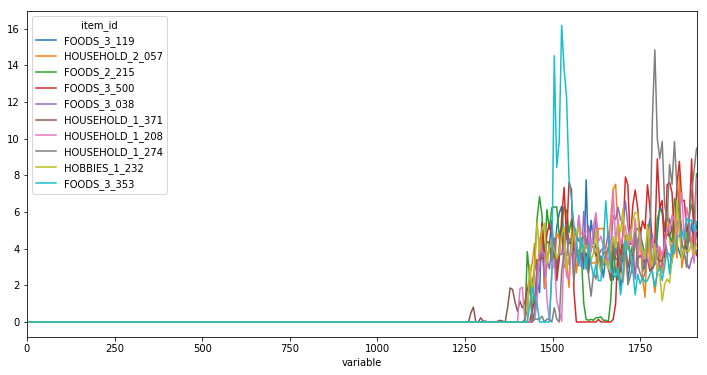

In [ ]:
# cluster 7
random.seed(1)
daily_sales_item_lookup_scaled_clustered.loc[7]\
    .T\
    .iloc[:, random.sample(range(daily_sales_item_lookup_scaled_clustered.loc[7].shape[0]), 10)]\
    .plot(figsize = (12,6))

Similar to cluster 1 - the series in cluster 7 are similar in that they all have a period of few sales at the begining before sales pick up. Unlike cluster 1 - where sales pick up around 300 days since the begining of the time frame, the series in cluster 7 pick up sales around 1300-1500 days into the time period.

They might all be pre-processed in the same way before training, by cutting of the first 1300 datapoints, as there is no signal to be learned before sales pick up 1300 days into the time period.

---

## Dynamic Time Warping

You might notice that according to the clustering method above, two series that might look "similar" to the human eye might not be in the same clusters **if they're not aligned**. For example, consider the following two series:

Text(0.5, 0, 'Days since start')

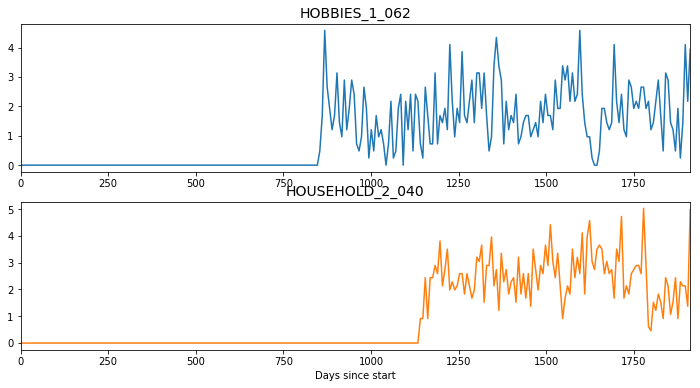

In [ ]:
# show two series that look similar but are misaligned, for demonstration purposes
fig, [ax1,ax2] = plt.subplots(nrows = 2, figsize = (12,6))
daily_sales_item_lookup_scaled_weekly["HOBBIES_1_062"].plot(ax = ax1, color = "C0")
daily_sales_item_lookup_scaled_weekly["HOUSEHOLD_2_040"].plot(ax = ax2, color = "C1")
ax1.set_title("HOBBIES_1_062", fontsize= 14)
ax2.set_title("HOUSEHOLD_2_040", fontsize= 14)
ax1.set_xlabel("")
ax2.set_xlabel("Days since start")

If you were to describe why these to series are alike you might say: _"They both start with zero sales, and then steady sales start."_

Heirarchical clustering is blind to these types of similarities, however, as it measures the similarity between vectors element-wise - for example using Euclidean distance. Thus, even two identical series might not be recognized as similar if they're shifted from one another.

To address this, I use a method for comparing misaligned time series called [Dynamic Time Warping](https://en.wikipedia.org/wiki/Dynamic_time_warping). This dynamic programming algorithm allows for elements in one series to be compared to elements in another series that are either _forward or backwards in time_. This allows for two series to be recognized as similar in shape, even if they're not aligned.

In this section, I demonstrate how one might use this method or a similar method to better group time series which share the same overall shape.

### Dynamic Time Warping distance: example

To get an intuition for how dynamic time warping (DTW) works, it's best to see an example. Using the two series from above:

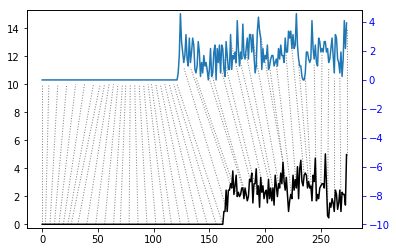

In [ ]:
## Align and plot with the Rabiner-Juang type VI-c unsmoothed recursion
dtw(
     daily_sales_item_lookup_scaled_weekly["HOUSEHOLD_2_040"],\
    daily_sales_item_lookup_scaled_weekly["HOBBIES_1_062"],\
    keep_internals=True,
    step_pattern=rabinerJuangStepPattern(3, "c"))\
    .plot(type="twoway",offset=10)

The chart above plots the two series, and uses dotted lines to indicate which points in time are compared betwen the two series.

You can see that the by looking forward/backwards in time, the flat parts of the series are compared, and the sections of the series that have positive sales are compared. This way, the two series aren't found to be dissimilar just because they start at a different time point.

---

### Clustering using DTW

Now I'll use the same hierarchical clustering method, but instead of using Euclidean distance to compare series, I'll use normalized DTW distance.

The DTW algorithm time complexity is quadratic in the size of each vector. If there are $m$ items in the dataset, each of them with $n$ elements, then the time to compute a full distance matrix between the series in this dataset is $O(m^2n^2)$, which would take a long time for a dataset of this size. To speed up this demonstration, I'll only use a sample of the items in this dataset.


In [ ]:
def get_dtw_diff_matrix(cols:list):
    """
    From a list of series, compute a distance matrix by computing the
    DTW distance of all pairwise combinations of series.
    """
    diff_matrix = {}
    cross = itertools.product(cols, cols)
    for (col1, col2) in cross:
        series1 = daily_sales_item_lookup_scaled_weekly[col1]
        series2 = daily_sales_item_lookup_scaled_weekly[col2]
        diff = dtw(
            series1,
            series2,
            keep_internals=True,
            step_pattern=rabinerJuangStepPattern(2, "c")
            )\
            .normalizedDistance
        diff_matrix[(col1, col2)] = [diff]
    return diff_matrix

In [ ]:
# sample 50 series, and compute the DTW distance matrix
random.seed(1)
sample_cols = random.sample(list(daily_sales_item_lookup_scaled_weekly.columns), 50)
dtw_diff_dict = get_dtw_diff_matrix(sample_cols)
# make into a df
dtw_diff_df = pd.DataFrame(dtw_diff_dict).T.reset_index()\
    .rename(columns = {"level_0":"item1", "level_1":"item2", 0:"diff"})\
    .pivot_table(index = "item1", columns = "item2", values = "diff")

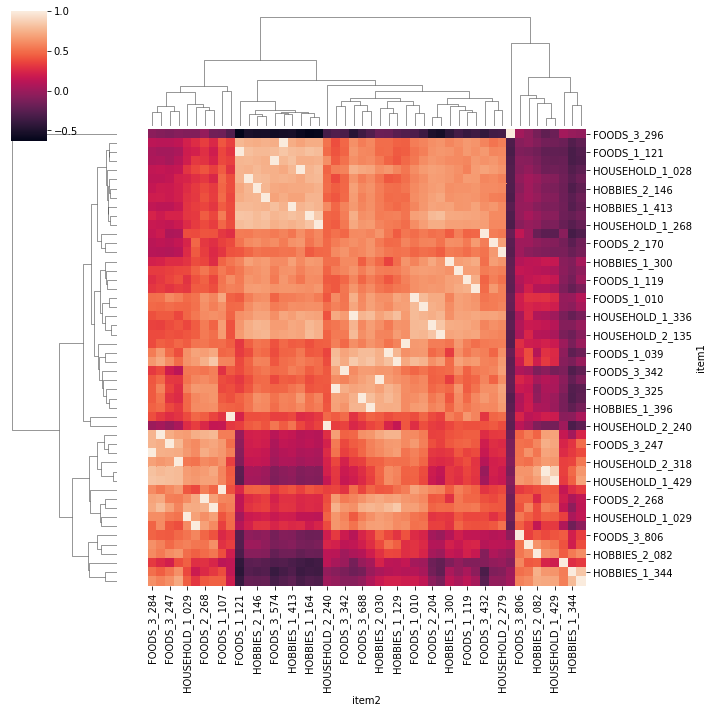

In [ ]:
# plot a similarity matrix, with a dendogram imposed
import seaborn as sns
sns.clustermap(1-dtw_diff_df)

#### Extract clusters

Using this DTW distance matrix, we can perform heirarchical clustering and extract the clusters formed using this new distance function.

In [ ]:
# ward clustering from difference matrix, where distance is Dynamic time warping distance instead of Euclidean
t = ward(dtw_diff_df)
# extract clusters
dtw_clusters = pd.DataFrame({"cluster":fcluster(t, 1.15)}, index = dtw_diff_df.index)

Text(0.5, 1.0, 'Frequency of DTW clusters')

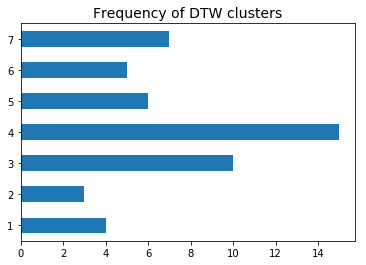

In [ ]:
dtw_clusters.cluster.value_counts().sort_index().plot.barh()
plt.title("Frequency of DTW clusters", fontsize = 14)

##### Showing cluster 1

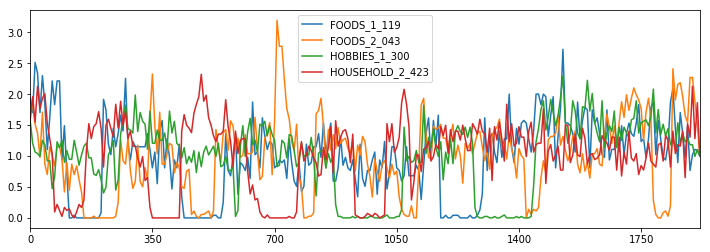

In [ ]:
# cluster 1
daily_sales_item_lookup_scaled_weekly.T.merge(
    dtw_clusters.loc[dtw_clusters.cluster == 1],
    left_index = True,
    right_index = True
)\
    .T\
    .plot(figsize = (12,4))

We can see that what the series in this cluster have in common is that they have intermittent of no sales, followed by periods of stable sales.

Showing the series pair-wise makes this clearer:

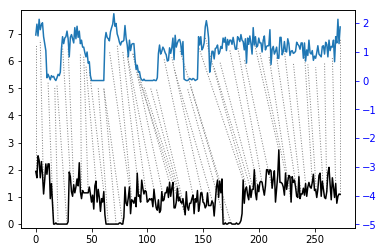

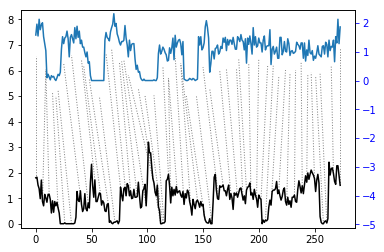

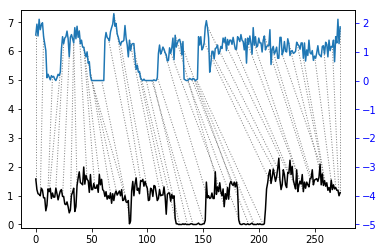

In [ ]:
def plot_dtw(series1:str, series2:str) -> None:
    dtw(daily_sales_item_lookup_scaled_weekly[series1],\
            daily_sales_item_lookup_scaled_weekly[series2],\
        keep_internals=True,
        step_pattern=rabinerJuangStepPattern(2, "c"))\
        .plot(type="twoway",offset=5)

plot_dtw("FOODS_1_119", "HOUSEHOLD_2_423")
plot_dtw("FOODS_2_043", "HOUSEHOLD_2_423")
plot_dtw("HOBBIES_1_300", "HOUSEHOLD_2_423")


You can see that the periods of no sales are aligned betwen the two series, and the periods with stable sales are aligned. According to to DTW distance function, the series above are shown to be similar, though if we compared them element-wise we would not be able to detect this.

We can repeat this for another cluster:

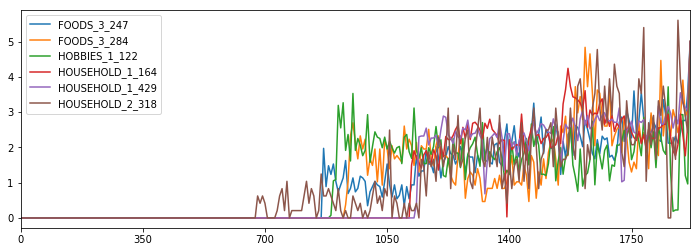

In [ ]:
# cluster 5
daily_sales_item_lookup_scaled_weekly.T.merge(
    dtw_clusters.loc[dtw_clusters.cluster == 5],
    left_index = True,
    right_index = True
)\
    .T\
    .plot(figsize = (12,4))

These series are similar in that they all start with few sales, and then experience a period of increasing sales. Seeing the DTW alignment:

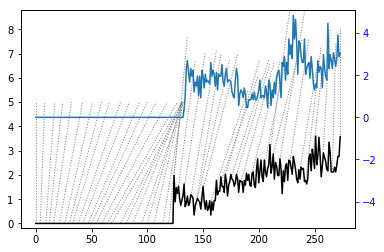

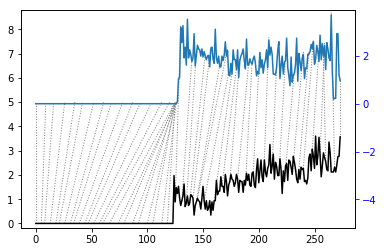

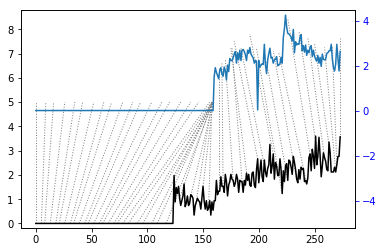

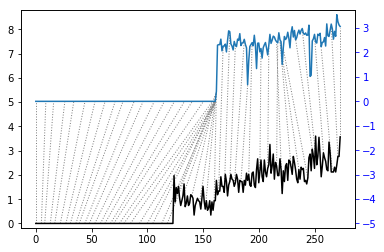

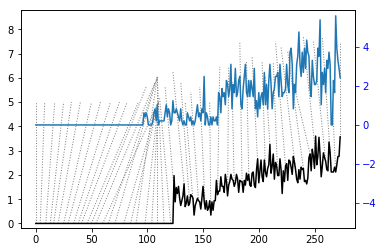

In [ ]:
# see which items are in cluster 5
plot_dtw("FOODS_3_247", "FOODS_3_284")
plot_dtw("FOODS_3_247", "HOBBIES_1_122")
plot_dtw("FOODS_3_247", "HOUSEHOLD_1_164")
plot_dtw("FOODS_3_247", "HOUSEHOLD_1_429")
plot_dtw("FOODS_3_247", "HOUSEHOLD_2_318")

---

## Conclusion and Next steps

In this notebook, I showed two methods one could use to cluster time series: heirarchical clustering using Euclidean distance and clustering using DTW distance.

As a follow up, I'd like to demonstrate how one could use these methods to improve modeling performance. For example: instead of training a model on the entire dataset, it may make sense to train one model per cluster, as the underlying structure of the series' are similar within a cluster. Or, one could pre-process (scaling, clipping) the series within a cluster in a similar way.